# Preliminary results for label detection & class

1. Can we find labels on images of herbarium specimens.
1. Can we determine if the label is typewritten, handwritten, or both.

In [1]:
from pathlib import Path
from textwrap import dedent
import pdb

from tqdm import tqdm
from ipywidgets import interact
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import transforms as T
from engine import train_one_epoch, evaluate
import utils

The Python environment.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -i -z -v -p torch,torchvision

EDT2019-06-22T19:05:36-04:00

CPython 3.7.3
IPython 7.5.0

torch 1.1.0
torchvision 0.3.0


Constants are useful autocomplete & edits.

In [3]:
DATA_DIR = Path('.') / 'data'
VAL_DIR = DATA_DIR / 'valid'
MODEL_DIR = DATA_DIR / 'models'

VAL_CSV = DATA_DIR / 'valid.csv'

BOX = 'box'
CAT = 'category'
PATH = 'path'
CLASS = 'class'
SUB_ID = 'subject_id'

DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True # Optimizes cudnn

CATS = ['background', 'handwritten', 'typewritten']
CLASSES = len(CATS)

STATE = MODEL_DIR / 'checkpoint_02.pth.tar'

Read in the hold-out (or validation) dataset. The model was not trained on this data.

**However the data did come from the same expedition as the training data & it may, therefore, contain a hidden bias.**

What we really want to do is test the *final* model on datasets from other herbaria.

In [4]:
val_df = pd.read_csv(VAL_CSV, index_col='subject_id').reset_index()

val_df.head()

,subject_id,category,class,box,path,original
0,2995202,typewritten,2,"[228, 459, 367, 568]",data/valid/2995202.jpg,data/images/2995202.jpg
1,2995203,typewritten,2,"[238, 462, 377, 572]",data/valid/2995203.jpg,data/images/2995203.jpg
2,2995205,typewritten,2,"[252, 486, 373, 564]",data/valid/2995205.jpg,data/images/2995205.jpg
3,2995213,typewritten,2,"[224, 474, 373, 566]",data/valid/2995213.jpg,data/images/2995213.jpg
4,2995216,handwritten,1,"[239, 462, 367, 562]",data/valid/2995216.jpg,data/images/2995216.jpg


We use this class to pass data to the model & to the GPU.

In [5]:
class LabelBabelDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        df[BOX] = df[BOX].apply(json.loads)
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        subject = self.df.iloc[idx]

        image = Image.open(subject[PATH]).convert('RGB')

        klass = int(subject[CLASS])
        labels = torch.full((1,), klass, dtype=torch.int64)

        boxes = [subject[BOX]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([subject[SUB_ID]])

        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target

    def __len__(self):
        return self.df.shape[0]

The model:
- Faster R-CNN with a ResNet50 backbone.
- The model was previously trained on the COCO dataset.
- The training dataset has 4865 labeled images.
- I trained the model for only 5 epochs
- There was almost no data augmentation

To do:
- Train the model for longer, possibly 2 orders of magnitude more epochs.

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, CLASSES)

In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
val_dataset = LabelBabelDataset(val_df, get_transform(train=False))

In [9]:
model.to(DEVICE)
model.eval();




In [10]:
state = torch.load(STATE)
model.load_state_dict(state['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
def intersetion_over_area(box1, box2):
    area1 = abs(box1[2] - box1[0]) * abs(box1[3] - box1[1])
    area2 = abs(box2[2] - box2[0]) * abs(box2[3] - box2[1])
    inter = (min(box1[2], box2[2]) - max(box1[0], box2[0])) \
        * (min(box1[3], box2[3]) - max(box1[1], box2[1]))
    inter = max(0, inter)
    return abs(inter / (area1 + area2 - inter))

In [12]:
def draw_rectangle(ax, bbox, color):
    wide = abs(bbox[2] - bbox[0])
    high = abs(bbox[3] - bbox[1])
    rect = patches.Rectangle(
        bbox[:2],
        wide, high,
        fill=False,
        edgecolor=color,
        lw=2)
    patch = ax.add_patch(rect)

In [13]:
def draw_text(ax, position, text, fontsize=10):
    ax.text(
        *position,
        text,
        verticalalignment='top',
        color='black',
        fontsize=fontsize,
        fontfamily='monospace',
        weight='bold',
        bbox=dict(
            boxstyle='round',
            facecolor='white',
            edgecolor='black'))

In [14]:
def show_results(idx, figsize):
    image, target = val_dataset[idx]

    subject_id = target['image_id'][0].numpy()

    t_class = CATS[target['labels'][0].numpy()]
    t_box = target['boxes'][0].numpy()

    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.axis('off')

    with torch.no_grad():
        prediction = model([image.to(DEVICE)])

    p_class = CATS[prediction[0]['labels'].cpu()[0].numpy()]
    p_box = prediction[0]['boxes'].cpu()[0].numpy()

    iou = round(intersetion_over_area(t_box, p_box), 2)
    class_flag = 'Equal' if t_class == p_class else 'NOT EQUAL'
    box_flag = '' if iou >= 0.8 else 'AREA MISMATCH'

    text = dedent(f"""\
            Subject ID:     {subject_id}
            Target:         {t_class} (blue)
            Top Prediction: {p_class} (red)
            Other predictions: (yellow)
            Class result:   {class_flag}
            IoU:            {iou:0.2} {box_flag}""")

    image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

    ax.imshow(image)
    draw_text(ax, (10, 10), text)

    draw_rectangle(ax, t_box, 'blue')

    # Show the boxes in reverse order so the seleted one is uncovered
    boxes = prediction[0]['boxes'].cpu().numpy()
    for i, box in enumerate(boxes[::-1], 1):
        color = 'red' if i == len(boxes) else 'yellow'
        draw_rectangle(ax, box, color)

    plt.show()


interact(
    show_results,
    idx=(0, val_df.shape[0] - 1),
    figsize=([6, 8, 10, 12, 15, 20, 25]))
# show_results(0)

# Sideways: 518-541  748-754
# Interesting: 763,1122
# Better: 1182,1213

interactive(children=(IntSlider(value=607, description='idx', max=1215), Dropdown(description='figsize', optio…

<function __main__.show_results(idx, figsize)>

In [15]:
def show_multiple_results(indices, height, width=None):
    ncols = len(indices)

    if not width:
        width = height * ncols * 0.667

    fig, axes = plt.subplots(
        nrows=1,
        ncols=ncols,
        figsize=(width, height),
        constrained_layout=True)

    for i, idx in enumerate(indices):
        image, target = val_dataset[idx]

        subject_id = target['image_id'][0].numpy()

        t_class = CATS[target['labels'][0].numpy()]
        t_box = target['boxes'][0].numpy()

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])

        p_class = CATS[prediction[0]['labels'].cpu()[0].numpy()]
        p_box = prediction[0]['boxes'].cpu()[0].numpy()

        iou = round(intersetion_over_area(t_box, p_box), 2)
        class_flag = 'Equal' if t_class == p_class else 'NOT EQUAL'
        box_flag = '' if iou >= 0.8 else 'AREA MISMATCH'

        text = dedent(f"""\
                Subject ID:     {subject_id}
                Target:         {t_class} (blue)
                Top Prediction: {p_class} (red)
                Other predictions: (yellow)
                Class result:   {class_flag}
                IoU:            {iou:0.2} {box_flag}""")

        image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

        axes[i].imshow(image)
        draw_text(axes[i], (10, 10), text)

        draw_rectangle(axes[i], t_box, 'blue')

        # Show the boxes in reverse order so the seleted one is uncovered
        boxes = prediction[0]['boxes'].cpu().numpy()
        for j, box in enumerate(boxes[::-1], 1):
            color = 'red' if j == len(boxes) else 'yellow'
            draw_rectangle(axes[i], box, color)

    for ax in axes.flat:
        ax.axis('off')

    plt.show()

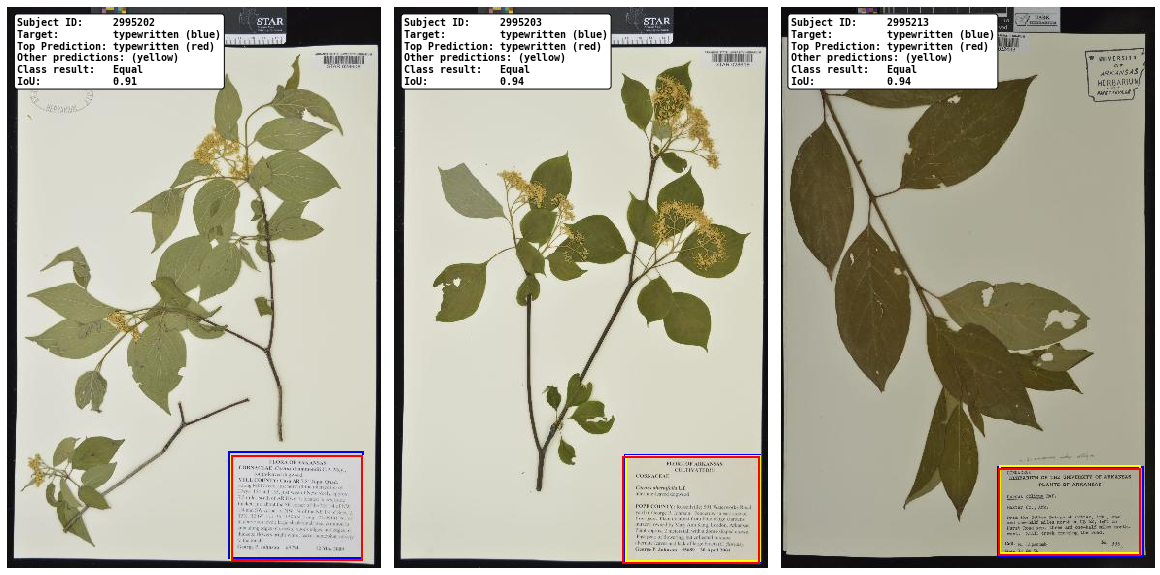

In [16]:
show_multiple_results([0, 1, 3], 8)

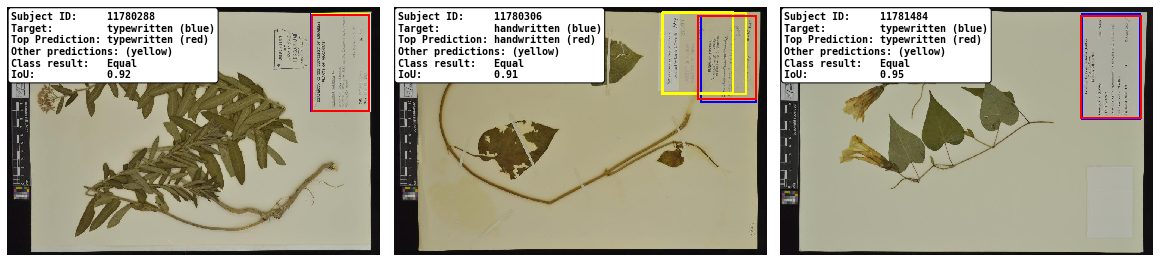

In [17]:
show_multiple_results([518, 520, 748], 4, 16)

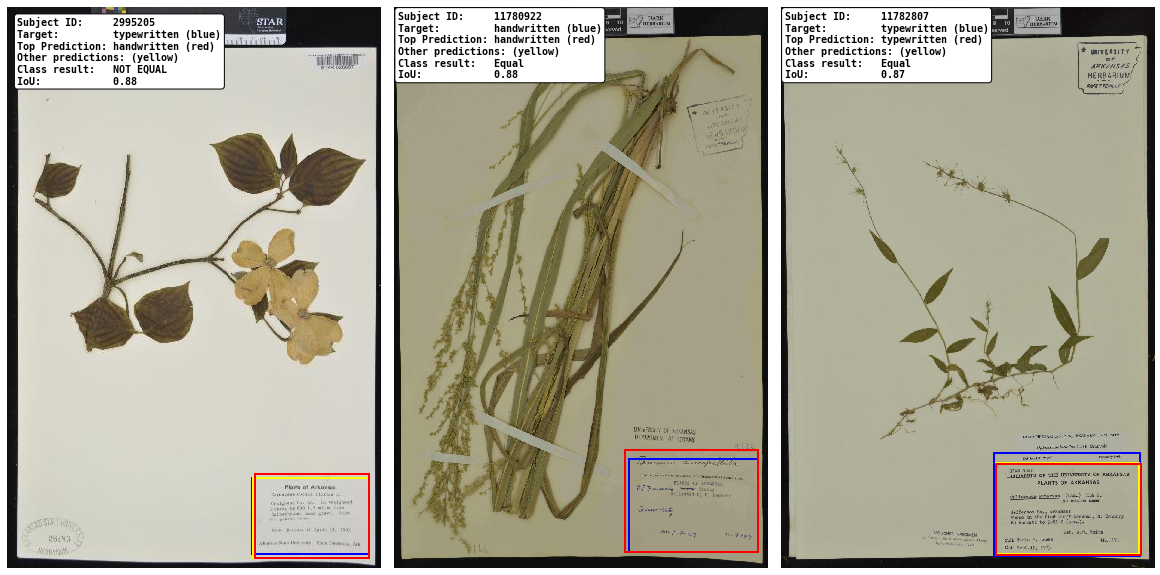

In [18]:
show_multiple_results([2, 637, 1029], 8)

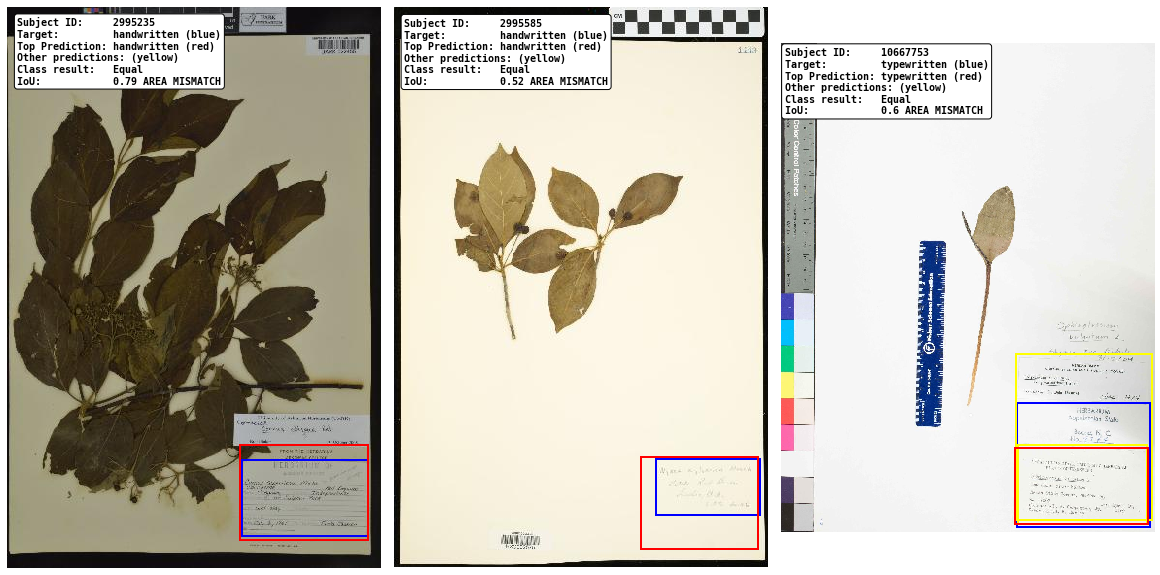

In [19]:
show_multiple_results([7, 67, 306], 8)

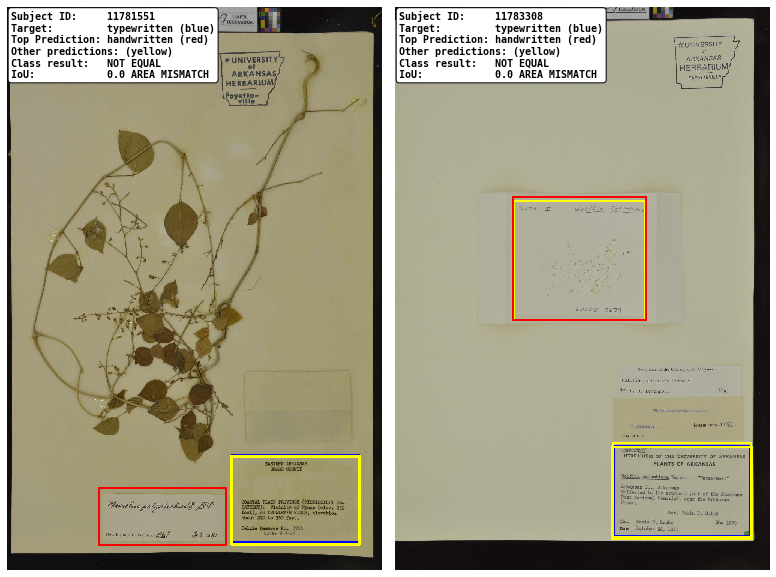

In [20]:
show_multiple_results([763, 1122], 8)

In [21]:
def bin_results():
    results = {
        'eq': 0,
        '1->2': [],
        '2->1': [],
        '>=90': 0,
        '<90': 0,
        '<80': [],
        'n': len(val_dataset),
    }

    for i, (image, target) in tqdm(enumerate(val_dataset)):

        image_id = target["image_id"][0].numpy().item()

        t_class = target['labels'][0].numpy()
        t_box = target['boxes'][0].numpy()

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])

        p_class = prediction[0]['labels'].cpu()[0].numpy()
        p_box = prediction[0]['boxes'].cpu()[0].numpy()

        if t_class == p_class:
            results['eq'] += 1
        elif t_class == 1:
            results['1->2'].append((i, image_id))
        else:
            results['2->1'].append((i, image_id))

        iou = round(intersetion_over_area(t_box, p_box), 2)

        if iou < 0.8:
            results['<80'].append((i, image_id))
        elif iou < 0.9:
            results['<90'] += 1
        else:
            results['>=90'] += 1

    return results


def print_results(results):
    n = results["n"]
    print(f'There are {n} items in the validation set.')
    print()

    per = round(results["eq"] / results["n"] * 100.0, 2)
    print(f'There were {results["eq"]} ({per}%) correctly identified classes')
    print()

    per = round(len(results["1->2"]) / results["n"] * 100.0, 2)
    print(f'Handwritten -> Typewritten errors ({per}%):')
    for result in results["1->2"]:
        print(result)
    print()

    per = round(len(results["2->1"]) / results["n"] * 100.0, 2)
    print(f'Typewritten -> Handwritten errors ({per}%):')
    for result in results["2->1"]:
        print(result)
    print()

    per = round(results[">=90"] / results["n"] * 100.0, 2)
    print(f'Intersection over union >= 90%: {results[">=90"]} ({per}%)')
    print()

    per = round(results["<90"] / results["n"] * 100.0, 2)
    print(f'Intersection over union 80-90%: {results["<90"]} ({per}%)')
    print()

    per = round(len(results["<80"]) / results["n"] * 100.0, 2)
    print(f'Intersection over union < 80%: {len(results["<80"])} ({per}%)')
    for result in results["<80"]:
    print(result)


# results = bin_results()
# print(results)

IndentationError: expected an indented block (<ipython-input-21-57b67c9f4154>, line 76)